In [5]:
import carfac as carfac_jax
import jax
import jax.numpy as jnp
import functools
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import numpy as np

In [6]:
def plot_spec(sound,sr):
    sound = np.array(sound)
    # Convert the audio to a Mel spectrogram
    S = librosa.feature.melspectrogram(y=sound, sr=sr, n_mels=128)
    # Convert the power spectrogram (amplitude squared) to decibel (dB) units
    S_dB = librosa.power_to_db(S, ref=np.max)
    # Plot the Mel spectrogram
    plt.figure(figsize=(5, 3))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

In [7]:
'''design and init CARFAC'''
n_ears = 1
params_jax = carfac_jax.CarfacDesignParameters()
params_jax.ears[0].car.linear_car = False
hypers_jax, weights_jax, state_jax = carfac_jax.design_and_init_carfac(
    params_jax
)

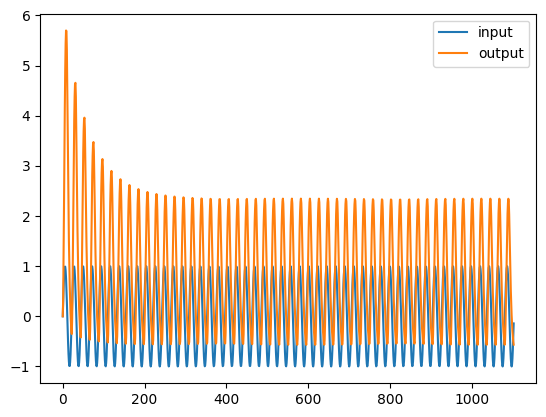

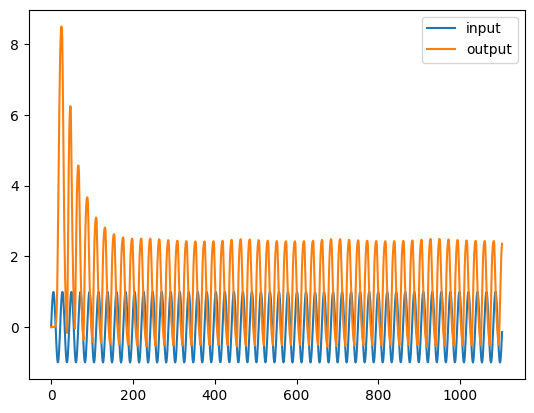

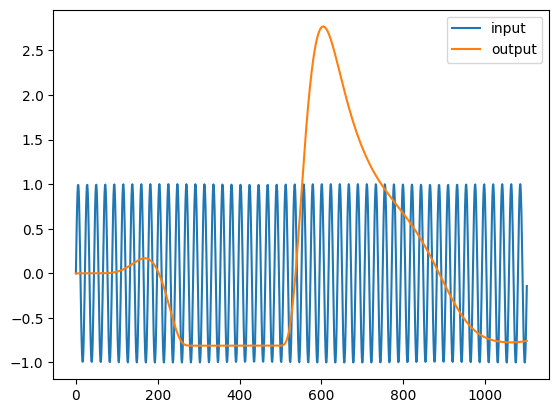

In [8]:
sr = 22050
time_step = jnp.arange(0,0.05*sr)/sr
sine_wave = jnp.sin(2*jnp.pi*time_step*1000)
naps_jax, state_jax, _, _, _ = carfac_jax.run_segment(
    sine_wave,  hypers_jax, weights_jax, state_jax, open_loop=False)
ch_list = [0,35,70]
for ch in ch_list:
    plt.plot(sine_wave, label = 'input')
    plt.plot(naps_jax[:,ch,0],label = 'output')
    plt.legend()
    plt.show()

In [ ]:
y, sr = librosa.load('download.wav')
print(sr)
naps_jax, state_jax, _, _, _ = carfac_jax.run_segment(
    y,  hypers_jax, weights_jax, state_jax, open_loop=False)
wave_ch0 = naps_jax[:,0,0]
wave_ch35 = naps_jax[:,35,0]
wave_ch70 = naps_jax[:,70,0]
print(wave_ch0.shape)
ipd.display(ipd.Audio(wave_ch0, rate=sr))
ipd.display(ipd.Audio(wave_ch35, rate=sr))
ipd.display(ipd.Audio(wave_ch70, rate=sr))
plot_spec(wave_ch0,sr)
plot_spec(wave_ch35,sr)
plot_spec(wave_ch70,sr)

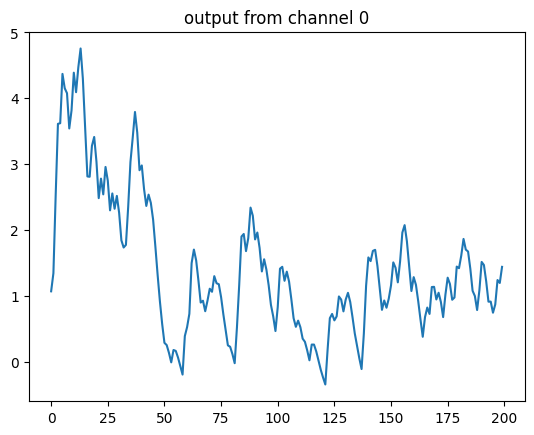

In [115]:
## First, define a loss and optionally make it JITted.
@functools.partial(jax.jit, static_argnames=('hypers',))
def loss(weights, input_waves, hypers, state):
  # A loss function for tests.
  naps_jax, state_jax, _, _, _ = carfac_jax.run_segment(
      input_waves, hypers, weights, state, open_loop=False
  )
  # For testing, just fit `naps` to 1.
  return (
      jnp.sum((naps_jax - 1.0) ** 2)
      /jnp.prod(jnp.asarray(naps_jax.shape)),
      [state_jax,naps_jax],
  )

## Second, generate some random input audio signal.
n_samp = 200
n_ears = 1
run_seg_input = jax.random.normal(jax.random.PRNGKey(1),(n_samp, n_ears))
## Third, computes gradients by `jax.grad`.
gfunc = jax.grad(loss, has_aux=True)
grad_jax, new_list = gfunc(weights_jax, run_seg_input, hypers_jax, state_jax)
new_state, naps_jax = new_list
plt.plot(naps_jax[:,0,:])
plt.title('output from channel 0')
plt.show()
## Now one can update `Weights` based on `grad_jax`.
# One can use a library like `Optax`. Here, for illustration, we can just do the
# gradient descent (stepsize=0.1) by,
new_weights = jax.tree.map(lambda x,y: x-0.0000001*y, weights_jax, grad_jax)
# Please note that: we currently put as many coefficients as possible into
# `Weights` but normally we don't need to train all of them (and some of the
# weights are much more sensitive than the others). One can selectively update
# part of the weights easily.

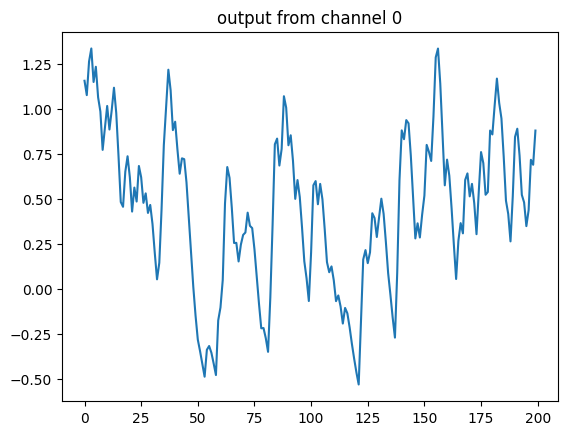

In [110]:
for i in range(1000):
    grad_jax, new_list = gfunc(new_weights, run_seg_input, hypers_jax, new_state)
    new_state, naps_jax= new_list
    new_weights = jax.tree.map(lambda x,y: x-0.000001*y, new_weights, grad_jax)
plt.plot(naps_jax[:,0,:])
plt.title('output from channel 0')
plt.show()

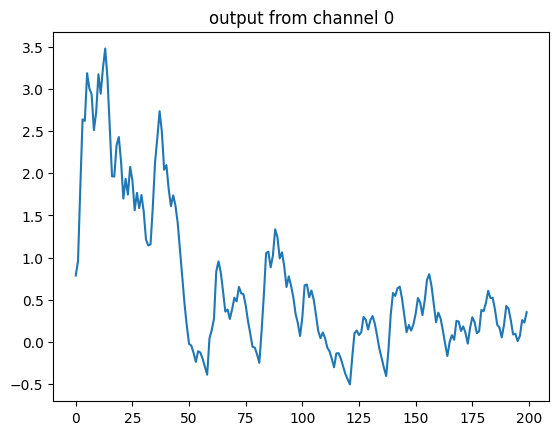

In [114]:
for i in range(1000):
    grad_jax, new_list = gfunc(new_weights, run_seg_input, hypers_jax, state_jax)
    new_state, naps_jax= new_list
    new_weights = jax.tree.map(lambda x,y: x-0.000001*y, new_weights, grad_jax)
plt.plot(naps_jax[:,0,:])
plt.title('output from channel 0')
plt.show()